In [43]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import re

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from string import punctuation

%matplotlib inline

In [2]:
# Раскомментируйте и скачайте эмбеддинги
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2022-10-07 21:18:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1,2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1,22G  21,1MB/s    in 61s     

2022-10-07 21:19:33 (20,5 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [350]:
#скачам также navec эмбеддинги
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!tar -xvf navec_hudlit_v1_12B_500K_300d_100q.tar

--2022-10-08 21:09:47--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50,56M  74,5MB/s    in 0,7s    

2022-10-08 21:09:48 (74,5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [2]:
def load_embeddings(file_path, pad_token='PAD', unk_token='UNK', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with open(file_path) as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
        max_words = vocab_size if max_words <= 0 else max_words

        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[pad_token] = 0
        embeddings.append(np.zeros(embedding_dim))

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=max_words, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == max_words:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [5]:
vocab, embeddings = load_embeddings('cc.ru.300.vec', max_words=100_000)

Reading embeddings file:   0%|          | 0/100000 [00:00<?, ?it/s]

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [4]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/home/nanosemantics/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/nanosemantics/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/nanosemantics/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


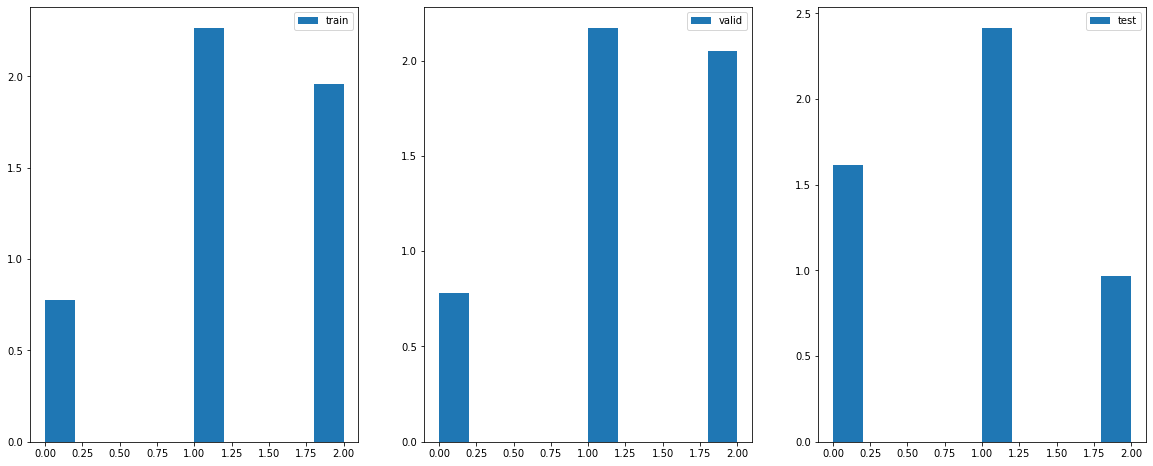

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))

axes[0].hist(train_dataset['label'], density=True, label='train')
axes[0].legend()

axes[1].hist(valid_dataset['label'], density=True, label='valid')
axes[1].legend()

axes[2].hist(test_dataset['label'], density=True, label='test')
axes[2].legend()

plt.show()

Баланс классов на тесте сильно отличается от того, что есть на трейне и валидации, это плохо, поэтому вероятнее всего на на тестовом датасете метрики будут отличаться от метрик на обучении.

Посмотрим на данные:

In [10]:
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)
val_df = pd.DataFrame(valid_dataset)

In [23]:
train_df[train_df['label'] == 0]['text'].sample(10).values

array(['"Watching some crap called ""Big Brother"". Okay. I may have been out of the loop for some time now but,... WTF!!"',
       '@user The 1st two reacted 2 the burning alive of 59 Hindus by Muslims in a train. Can u tell me how Muslims will react if burnt alive?',
       '&gt;Gamergate is a hate group &gt;Amazon Prime Day is going to be bigger than Black Friday  What do these two things have in common....',
       'Damn i just gave her a reason to ground me 4 da whole festve season... Omigod wont evn go ta my pensdown on mon:( shidd!',
       "@user That 4th down play in the Colts game back in 09 is one of the dumbest decisions I've ever seen",
       '@user it\'s pretty sad, Rooney may be the last one for a long time now unless players like sterling, Kane, stones, Wilson"',
       '"Israel razes West Bank home of Modi\'in hammer terrorist: Last Tuesday, the 39-year-old hacked and wounded two ...',
       'Rick Perry may by a vineyard and retire so he can whine all day.',
       '

In [24]:
train_df[train_df['label'] == 1]['text'].sample(10).values

array(["That sense of accomplishment when you've sat in front of your computer for 2 hours straight Apple Watch says you've met your exercise goal.",
       '#USOpen2015 Eeeeek! 3rd set tiebreak for Murray &amp; Anderson! Konta v Kvitova on serve with the Briton serving very well!',
       '@user @user April, sure seems he is heading in that direction after meeting with Obama and Muslims."',
       'LSU needs to do one thing to beat Bama. Run! And stop the Run! Win it in the 4th quarter\\u002c GEAUX TIGERS!!',
       'What to expect from Apple in about 3 hours and 45 minutes',
       'Back in rehearsal on Monday with The Woman In Black after a summer with The Sound of Music.',
       '"I think tomorrow when I get out of class I\'m going to Wal mart and buying apples , caramel squares,and razor blades to see the cashiers face"',
       "Currently finishing up a brief musical history of the Bond films. Sam Smith's Writing's On The Wall just became the 24th Bond Song!",
       'AL 6-2 NL 

In [89]:
train_df[train_df['label'] == 2]['text'].sample(10).values

array(['@user that\'s alright. Keep fighting the good fight &amp; as with Charlie Hebdo, long may the real France endure. A great people."',
       '@user Took my son to see Ant-Man yesterday and the #ForceAwakens trailer played before. 1st time seeing it on big screen. #AWESOME',
       '"Tina, Mustard and Pudding are climbing Mount Snowdon tomorrow to raise funds for the Pet Welfare Alliance. Your...',
       'Super pumped to celebrate with my K/1st graders who made it through Summer Olympics: Training in Truth @user #lovekids #loveJesus',
       "@user yeah I'm ready for bed. Long but fun day at Disneyland tomorrow.",
       '"All I want for Christmas is licensing please August Alsina, Future, Kendrick Lamar, Miguel, Rick Ross , Lil Wayne...',
       '"I want a fansign from Twee, June, Mikasa and Jen o3o"',
       "I've amassed 1.5 million credits in ME3 for the Retaliation launch tomorrow. More than a little excited #ME3 #mybodyisready",
       'And that is why messi is the best in

In [25]:
class Tokenizer:
    
    def __init__(self, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = ToktokTokenizer()  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length
        
    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
#         tokens = self._base_tokenizer.tokenize(text)
        tokens = re.findall(r'\b[A-z]+\b', text)
        tokens = [token.lower().strip(punctuation) for token in tokens if token not in punctuation]
        return tokens
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        tokens_indices = []
        for token in tokenized_text:
            if token in self.token2index:
                idx = self.token2index[token]
                tokens_indices.append(idx)
            else:
                tokens_indices.append(self.unk_index)
        return tokens_indices
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        prev_idx = -1
        norep_tokens_indices = []

        for idx in tokens_indices:
            if idx != prev_idx:
                norep_tokens_indices.append(idx)
                prev_idx = idx
                
        if len(norep_tokens_indices) < self.max_length:
            norep_tokens_indices += [self.pad_index for _ in range(self.max_length - len(norep_tokens_indices))]
        elif len(norep_tokens_indices) > self.max_length:
            norep_tokens_indices = norep_tokens_indices[:self.max_length]
        return norep_tokens_indices
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужного размера (self.max_length)
        """
        tokens = self.tokenize(text)
        tokens_indices = self.indexing(tokens)
        padded_tokens_indices = self.padding(tokens_indices)
        return padded_tokens_indices
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        t = Tokenizer(self.token2index, self.pad_token, self.unk_token, self.max_length)
        for sample in batch:
            text, label = sample['text'], sample['label']
            tokenized_text = t(text)
            tokenized_texts.append(tokenized_text)
            labels.append(label)
            
        tokenized_texts = torch.tensor(tokenized_texts)
        labels = torch.tensor(labels)
        
        return tokenized_texts, labels

In [26]:
tokenizer = Tokenizer(token2index=vocab, pad_token='PAD', unk_token='UNK', max_length=64)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)

In [27]:
for x, y in train_loader:
    break

In [28]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

## Выбор метрики
Я выбрал метрику f1 score с average='weighted', по той причине, что данная метрика подходит для оценки задач классификации и представляет собой среднее гармоническое значение между точностью и полнотой, а параметр average со значением weighted позволяет рассчитывать данную метрику с учетом количества (весов) представителей разных классов в датасете, а т.к. у нас дисбаланс классов, то это более объективная оценка.

In [35]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, embedding_dim, embeddings):
        super(DeepAverageNetwork, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float32), padding_idx=0)
        self.linear_1 = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
        self.linear_2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
        self.batch_norm_1 = torch.nn.BatchNorm1d(self.embedding_dim // 2)
        self.batch_norm_2 = torch.nn.BatchNorm1d(self.embedding_dim // 4)
        self.clf_layer = nn.Linear(self.embedding_dim // 4, 3)
        self.activation = nn.Softmax(dim=1)
        
    def forward(self, x):
        emb = self.embedding(x)
        average_emb = self.mean_out_pads(emb, x)
        out_lin_1 = F.dropout(F.relu(self.batch_norm_1(self.linear_1(average_emb))), p=0.3)
        out_lin_2 = F.dropout(F.relu(self.batch_norm_2(self.linear_2(out_lin_1))), p=0.3)
        out_clf = self.clf_layer(out_lin_2)
        probs = self.activation(out_clf)
        return probs
    
    def mean_out_pads(self, out_emb, x):
        """
        Функция для усреднения эмбеддингов с учетом количества pad-ов
        """
        average_embs = torch.zeros([out_emb.shape[0], out_emb.shape[2]]).to(out_emb.device)
        for i in range(x.shape[0]):
            not_null_idx = torch.where(x[i] != 0)[0]
            not_null_embs = out_emb[i][not_null_idx, :]
            average_emb = not_null_embs.mean(axis=0)
            average_embs[i] = average_emb
        return average_embs

In [53]:
#напишем функции обучения, теста, рисования графиков, confusion matrix

def train_model(model, train_loader, valid_loader, test_loader, n_epochs, optimizer, loss_func):
    
    NUM_EPOCHS = n_epochs  # Задайте количество эпох

    model.to(device)
    train_losses, validation_losses = [], []
    train_f1, val_f1 = [], []

    for n_epoch in tqdm(range(NUM_EPOCHS)):
        model.train()
        all_labels = np.empty(0)
        all_pred_labels = np.empty(0)
        for batch in train_loader:
            optimizer.zero_grad()
            batch = (t.to(device) for t in batch)
            ids, labels = batch
            pred_probs = model.forward(ids)
            pred_labels = pred_probs.argmax(axis=1).detach().cpu().numpy()
            loss = loss_func(pred_probs, labels)
            labels = labels.detach().cpu().numpy()
            all_labels = np.hstack([all_labels, labels])
            all_pred_labels = np.hstack([all_pred_labels, pred_labels])
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        epoch_train_f1 = f1_score(all_labels, all_pred_labels, average='weighted')
        train_f1.append(epoch_train_f1)

        all_labels = np.empty(0)
        all_pred_labels = np.empty(0)

        model.eval()
        for batch in valid_loader:
            batch = (t.to(device) for t in batch)
            ids, labels = batch
            with torch.no_grad():
                pred_probs = model.forward(ids)
            pred_labels = pred_probs.argmax(axis=1).detach().cpu().numpy()
            loss = loss_func(pred_probs, labels)
            labels = labels.detach().cpu().numpy()
            all_labels = np.hstack([all_labels, labels])
            all_pred_labels = np.hstack([all_pred_labels, pred_labels])
            validation_losses.append(loss.item())

        epoch_val_f1 = f1_score(all_labels, all_pred_labels, average='weighted')
        print(f'Epoch {n_epoch + 1} ... train f1 score {epoch_train_f1:.2f} ... validation f1 score {epoch_val_f1:.2f} ... train loss {np.mean(train_losses[-len(train_loader):]):.2f} ... val loss {np.mean(validation_losses[-len(valid_loader):]):.2f}')
        print('-' * 120)
        val_f1.append(epoch_val_f1)
        
    test_model(model, test_loader, loss_func)
    plot_metrics(train_losses, validation_losses, train_f1, val_f1)
    return model
    
def test_model(model, test_loader, loss_func):
    all_labels = np.empty(0)
    all_pred_labels = np.empty(0)
    test_losses = []

    model.eval()
    for batch in test_loader:
        batch = (t.to(device) for t in batch)
        ids, labels = batch
        with torch.no_grad():
            pred_probs = model.forward(ids)
        pred_labels = pred_probs.argmax(axis=1).detach().cpu().numpy()
        loss = loss_func(pred_probs, labels)
        labels = labels.detach().cpu().numpy()
        all_labels = np.hstack([all_labels, labels])
        all_pred_labels = np.hstack([all_pred_labels, pred_labels])
        test_losses.append(loss.item())
    
    test_f1 = f1_score(all_labels, all_pred_labels, average='weighted')
    print(f'test f1 score {test_f1:.2f} ... test loss {np.mean(test_losses):.2f}')
    print('-' * 120)
    print(classification_report(all_labels, all_pred_labels, ))
    plot_confusion_matrix(all_labels, all_pred_labels)
    
def plot_metrics(train_losses, validation_losses, train_f1, val_f1):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    axes[0][0].plot(train_losses, label='train loss')
    axes[0][0].legend()

    axes[0][1].plot(validation_losses, label='validation loss')
    axes[0][1].legend()

    axes[1][0].plot(train_f1, label='train f1 score')
    axes[1][0].legend()

    axes[1][1].plot(val_f1, label='val f1 score')
    axes[1][1].legend()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 ... train f1 score 0.45 ... validation f1 score 0.46 ... train loss 1.05 ... val loss 1.03
------------------------------------------------------------------------------------------------------------------------
Epoch 2 ... train f1 score 0.47 ... validation f1 score 0.46 ... train loss 1.01 ... val loss 1.01
------------------------------------------------------------------------------------------------------------------------
Epoch 3 ... train f1 score 0.48 ... validation f1 score 0.47 ... train loss 1.00 ... val loss 1.01
------------------------------------------------------------------------------------------------------------------------
Epoch 4 ... train f1 score 0.49 ... validation f1 score 0.47 ... train loss 0.99 ... val loss 1.00
------------------------------------------------------------------------------------------------------------------------
Epoch 5 ... train f1 score 0.49 ... validation f1 score 0.45 ... train loss 0.99 ... val loss 1.01
---------------------

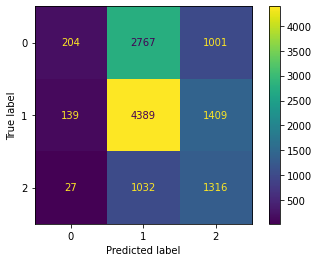

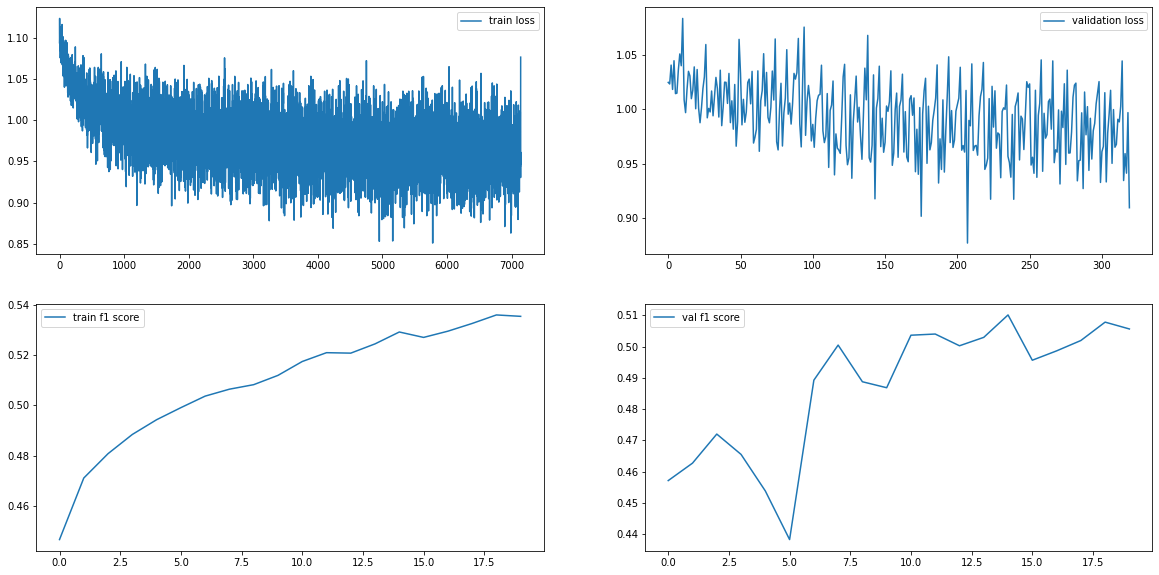

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DeepAverageNetwork(300, embeddings)
lr = 1e-4
n_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
ce_loss = torch.nn.CrossEntropyLoss()

trained_model = train_model(model, train_loader, valid_loader, test_loader, n_epochs, optimizer, ce_loss)

Модель не переобучилась, лосс на валидации и трейне не растет.

Качество получилось очень низкое, вероятнее всего проблема либо в слабой архитектуре, либо в использованных эмбеддингах. Попробуем использовать эмбеддинги получше, из библиотеки Navec.

In [49]:
class DeepAverageNetworkNavec(nn.Module):
    def __init__(self, embedding_dim, navec_embeddings):
        super(DeepAverageNetworkNavec, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = NavecEmbedding(navec_embeddings)
        self.linear_1 = nn.Linear(self.embedding_dim, self.embedding_dim // 2)
        self.linear_2 = nn.Linear(self.embedding_dim // 2, self.embedding_dim // 4)
        self.batch_norm_1 = torch.nn.BatchNorm1d(self.embedding_dim // 2)
        self.batch_norm_2 = torch.nn.BatchNorm1d(self.embedding_dim // 4)
        self.clf_layer = nn.Linear(self.embedding_dim // 4, 3)
        self.activation = nn.Softmax(dim=1)
        
    def forward(self, x):
        emb = self.embedding(x)
        average_emb = self.mean_out_pads(emb, x)
        out_lin_1 = F.dropout(F.relu(self.batch_norm_1(self.linear_1(average_emb))), p=0.3)
        out_lin_2 = F.dropout(F.relu(self.batch_norm_2(self.linear_2(out_lin_1))), p=0.3)
        out_clf = self.clf_layer(out_lin_2)
        probs = self.activation(out_clf)
        return probs
    
    def mean_out_pads(self, out_emb, x):
        average_embs = torch.zeros([out_emb.shape[0], out_emb.shape[2]]).to(out_emb.device)
        for i in range(x.shape[0]):
            not_null_idx = torch.where(x[i] != 0)[0]
            not_null_embs = out_emb[i][not_null_idx, :]
            average_emb = not_null_embs.mean(axis=0)
            average_embs[i] = average_emb
        return average_embs

In [51]:
from navec import Navec
from slovnet.model.emb import NavecEmbedding

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

def create_vocab_from_navec(navec):
    navec = Navec.load(path)
    return {word:navec.vocab[word] for word in navec.vocab.words}       

In [54]:
token2index = create_vocab_from_navec(path)

tokenizer = Tokenizer(token2index=token2index, pad_token='<pad>', unk_token='<unk>', max_length=128)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)

In [55]:
from transformers import Adafactor

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 ... train f1 score 0.47 ... validation f1 score 0.51 ... train loss 1.02 ... val loss 1.00
------------------------------------------------------------------------------------------------------------------------
Epoch 2 ... train f1 score 0.52 ... validation f1 score 0.52 ... train loss 0.98 ... val loss 0.97
------------------------------------------------------------------------------------------------------------------------
Epoch 3 ... train f1 score 0.54 ... validation f1 score 0.54 ... train loss 0.96 ... val loss 0.96
------------------------------------------------------------------------------------------------------------------------
Epoch 4 ... train f1 score 0.55 ... validation f1 score 0.51 ... train loss 0.95 ... val loss 0.97
------------------------------------------------------------------------------------------------------------------------
Epoch 5 ... train f1 score 0.56 ... validation f1 score 0.57 ... train loss 0.94 ... val loss 0.95
---------------------

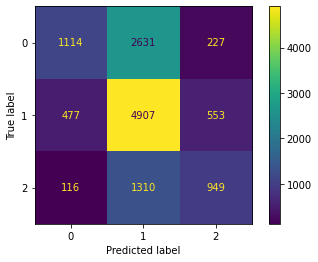

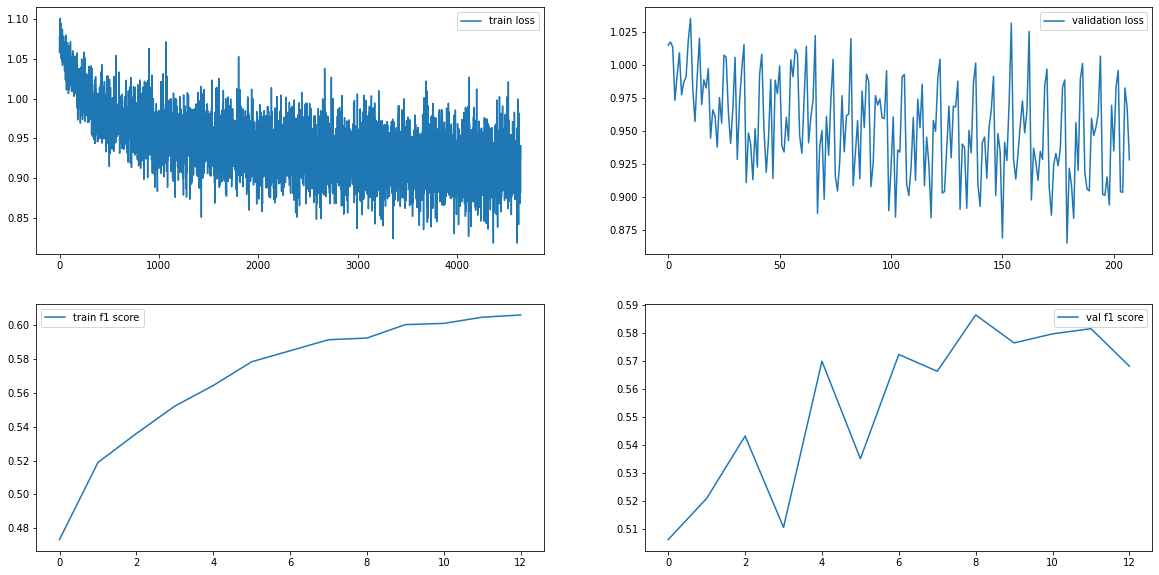

In [88]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
navec_embs = Navec.load(path)
model = DeepAverageNetworkNavec(300, navec_embs)
lr = 1e-4
n_epochs = 13
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = Adafactor(model.parameters())
ce_loss = torch.nn.CrossEntropyLoss()

trained_model = train_model(model, train_loader, valid_loader, test_loader, n_epochs, optimizer, ce_loss)

## Выводы

Данная модель лучше, чем предыдущая на Fasttext эмбеддингах, но качество все равно никуда не годится. Переобучилась если только совсем немного на последних двух эпохах, но это не критично, учитывая тот факт что для продакшена такая модель все равно не подходит. 

Модель больше всего ошибается на нейтральных примерах (по графику confusion matrix), т.е. не находит разницы между между нейтральными и позитивными/отрицательными примерами - это действительно сложно. Это происходит по той причине, что в данных твитов есть множество слов, которые не содержатся в словарях эмбеддингов, а мы для этих слов задаем токен UNK, хотя они по факту являются наиболее определяющими для определения тональности, по типу Fuckkk, kakkest, haha и т.д. Плюс я выкидываю знаки препинания из предобработки, что плохо для подобных задач, т.к. они также могут нести в себе смысл сентимента.

Также проблема низкого качества моделей заключается в том, что DAN архитектура модели слишком слабая для подобной задачи, даже для бейзлайна она не подходит. Выше качество удалось бы добиться с использованием хотя бы LSTM или моделей на архитектуре трансформеров. Плюсом использования трансформеров является то, что они имеют в своих весах знания о языке, а токенизатор sentence piece позволяет обрабатывать более редкие слова и иметь представления в виде эмбеддингов для них. Использовать трансформеры в этой задаче мне было уже лень, но вот пример использования трансформенной модели обученной на 7 фолдах для задачи классификации текстов обращений: https://github.com/tumanov-a/kursk_ml/blob/main/train_model.ipynb